In [81]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from datetime import datetime

In [82]:
# Read the dataset
df = pd.read_csv('startup_cleaned.csv')

In [83]:
# Display the first few rows
df.head()

,date,startup,vertical,subvertical,city,investors,round,amount
0,2020-09-01,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,1650.000000
1,2020-01-13,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,66.399250
2,2020-09-01,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,151.460595
3,2020-02-01,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,24.750000
4,2020-02-01,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,14.850000


In [84]:
# Get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2822 non-null   object 
 1   startup      2822 non-null   object 
 2   vertical     2822 non-null   object 
 3   subvertical  2078 non-null   object 
 4   city         2822 non-null   object 
 5   investors    2822 non-null   object 
 6   round        2822 non-null   object 
 7   amount       2822 non-null   float64
dtypes: float64(1), object(7)
memory usage: 176.5+ KB


In [85]:
# Get statistical summary
df.describe()

,amount
count,2822.000000
mean,105.064421
std,853.454660
min,0.000000
25%,0.000000
50%,4.125000
75%,33.000000
max,32175.000000


# Exploratory Data Analysis and Data Cleaning

Let's perform a comprehensive cleaning and analysis of the Indian startup funding data.

In [86]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of missing values:")
print(missing_percentage)

Missing values in each column:
date             0
startup          0
vertical         0
subvertical    744
city             0
investors        0
round            0
amount           0
dtype: int64

Percentage of missing values:
date            0.000000
startup         0.000000
vertical        0.000000
subvertical    26.364281
city            0.000000
investors       0.000000
round           0.000000
amount          0.000000
dtype: float64


In [87]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

Number of duplicate rows: 0


## Data Cleaning

Let's clean the dataset to address the anomalies and standardize the values.

In [88]:
# Clean the date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract year and month for time-based analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

# Create a date period column for grouping by month
df['month_year'] = df['date'].dt.strftime('%Y-%m')

In [89]:
# Clean startup names
# Some startup names have special characters or incorrect formatting
df['startup'] = df['startup'].astype(str)
df['startup'] = df['startup'].str.replace('"', '')
df['startup'] = df['startup'].str.replace("'", "")
df['startup'] = df['startup'].str.replace(r'\\xe2\\x80\\x99s', "'s", regex=True)
df['startup'] = df['startup'].str.replace(r'\\x[a-fA-F0-9]{2}', '', regex=True)
df['startup'] = df['startup'].str.strip()

# Check the unique values after cleaning
print(f"Number of unique startups: {df['startup'].nunique()}")

# Display a sample of cleaned startup names
df['startup'].sample(5)

Number of unique startups: 2299


372     EarlySalary
2067      BitGiving
1576       Bonhomia
871     Be U Salons
40            GOQii
Name: startup, dtype: object

In [90]:
# Clean city names
df['city'] = df['city'].astype(str)
df['city'] = df['city'].str.replace(',', '').str.strip()

# Standardize major city names
city_mapping = {
    'Gurgaon': 'Gurugram',
    'New Delhi': 'Delhi',
    'Bangalore': 'Bengaluru',
    'Mumbai': 'Mumbai',
    'Pune': 'Pune',
    'Hyderabad': 'Hyderabad',
    'Chennai': 'Chennai',
    'Kolkata': 'Kolkata',
    'Ahmedabad': 'Ahmedabad',
    'Noida': 'Noida',
    'Gurgaon/Bangalore': 'Gurugram',
    'Bangalore/USA': 'Bengaluru',
    'nan': 'Unknown'
}

# Apply city standardization for major cities
for old_name, new_name in city_mapping.items():
    df.loc[df['city'].str.contains(old_name, case=False), 'city'] = new_name

# For cities not in our mapping, take the first city name if multiple are listed
df.loc[~df['city'].isin(list(city_mapping.values())), 'city'] = df.loc[~df['city'].isin(list(city_mapping.values())), 'city'].str.split('/').str[0]

# Count the occurrences of each city
city_counts = df['city'].value_counts()
print("Top 10 cities by startup count:")
print(city_counts.head(10))

Top 10 cities by startup count:
city
Bengaluru    841
Mumbai       560
Delhi        455
Gurugram     336
Pune         112
Hyderabad    100
Chennai       98
Noida         93
Ahmedabad     38
Jaipur        30
Name: count, dtype: int64


In [91]:
# Clean amount column and convert to numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Replace NaN values with 0 for amount
df['amount'] = df['amount'].fillna(0)

# Create funding ranges for better analysis
df['funding_range'] = pd.cut(
    df['amount'], 
    bins=[0, 1, 10, 50, 100, 500, float('inf')],
    labels=['<1Cr', '1-10Cr', '10-50Cr', '50-100Cr', '100-500Cr', '>500Cr']
)

# Display the distribution of funding ranges
funding_range_counts = df['funding_range'].value_counts().sort_index()
print("Distribution of funding ranges:")
print(funding_range_counts)

Distribution of funding ranges:
funding_range
<1Cr         115
1-10Cr       758
10-50Cr      490
50-100Cr     182
100-500Cr    269
>500Cr        91
Name: count, dtype: int64


In [92]:
# Clean round column
df['round'] = df['round'].astype(str).str.strip()

# Standardize round names
round_mapping = {
    'Seed Funding': 'Seed',
    'Seed/ Angel Funding': 'Seed',
    'Seed/Angel Funding': 'Seed',
    'Angel Funding': 'Angel',
    'Angel / Seed Funding': 'Angel',
    'Angel Round': 'Angel',
    'Private Equity Round': 'Private Equity',
    'Private Equity': 'Private Equity',
    'Debt Funding': 'Debt',
    'Debt': 'Debt',
    'Bridge Round': 'Bridge',
    'Series A': 'Series A',
    'Series B': 'Series B',
    'Series C': 'Series C',
    'Series D': 'Series D',
    'Series E': 'Series E',
    'Series F': 'Series F',
    'Series G': 'Series G',
    'Series H': 'Series H',
    'Series J': 'Series J',
    'nan': 'Unknown'
}

# Apply round standardization
for old, new in round_mapping.items():
    df.loc[df['round'].str.contains(old, case=False), 'round'] = new

# Display the distribution of funding rounds
round_counts = df['round'].value_counts()
print("Distribution of funding rounds:")
print(round_counts.head(10))

Distribution of funding rounds:
round
Seed                    1372
Private Equity          1265
Angel                     44
Series A                  33
Debt                      26
Series B                  20
Series C                  14
Series D                  12
Seed Round                 7
Seed / Angle Funding       3
Name: count, dtype: int64


In [93]:
# Clean vertical (industry sector) column
df['vertical'] = df['vertical'].astype(str).str.strip()

# Standardize vertical names
vertical_mapping = {
    'E-Commerce': 'eCommerce',
    'Ecommerce': 'eCommerce',
    'ECommerce': 'eCommerce',
    'Consumer Internet': 'Consumer Tech',
    'Technology': 'Tech',
    'FinTech': 'Fintech',
    'Fin-Tech': 'Fintech',
    'Food and Beverage': 'Food & Beverage',
    'Food & Beverages': 'Food & Beverage',
    'Healthcare': 'Health',
    'Health and Wellness': 'Health',
    'Education': 'EdTech',
    'Ed-Tech': 'EdTech',
    'Transport': 'Transportation',
    'Hospitality': 'Hospitality',
    'Logistics': 'Logistics',
    'Real Estate': 'Real Estate',
    'Finance': 'Finance',
    'nan': 'Unknown'
}

# Apply vertical standardization
for old, new in vertical_mapping.items():
    df.loc[df['vertical'].str.contains(old, case=False), 'vertical'] = new

# Count the occurrences of each vertical
vertical_counts = df['vertical'].value_counts()
print("Top 10 verticals:")
print(vertical_counts.head(10))

Top 10 verticals:
vertical
Consumer Tech      929
Tech               484
eCommerce          329
Health              91
Unknown             74
Logistics           65
EdTech              59
Food & Beverage     34
Fintech             17
Real Estate         15
Name: count, dtype: int64


In [94]:
# Clean investors column and count number of investors
df['investors'] = df['investors'].astype(str)
df['investor_count'] = df['investors'].str.count(',') + 1
df.loc[df['investors'] == 'nan', 'investor_count'] = 0

# Display investor count distribution
print("Distribution of investor count:")
print(df['investor_count'].value_counts().sort_index().head(10))

Distribution of investor count:
investor_count
1     1601
2      567
3      274
4      193
5       91
6       51
7       31
8       10
9        2
10       2
Name: count, dtype: int64


## Exploratory Data Analysis

Now let's analyze the cleaned data to gain insights into the Indian startup ecosystem.

Plotly visualization failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Falling back to matplotlib for visualization...


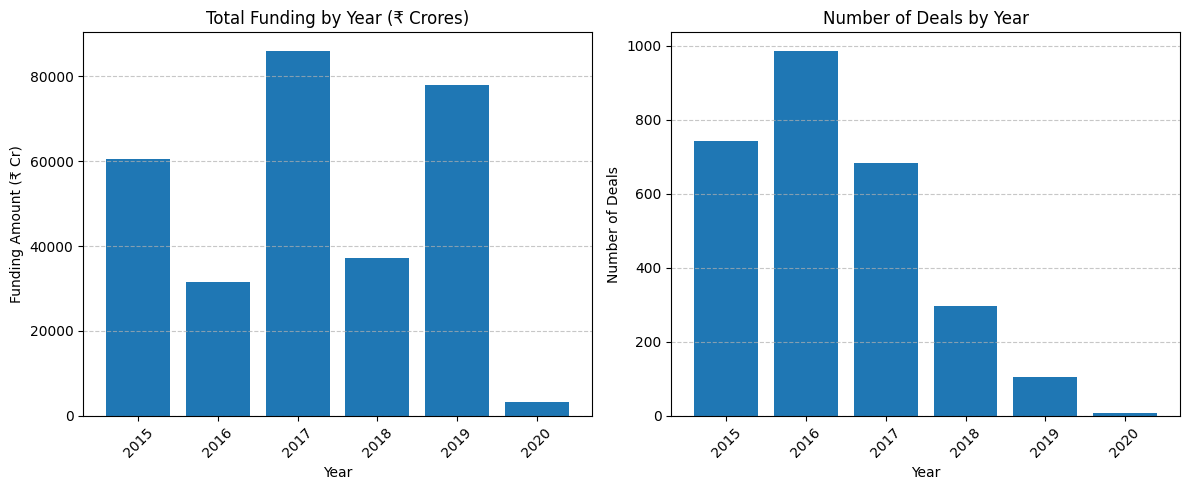

In [95]:
# Install required dependencies first
try:
    import importlib.util
    if not importlib.util.find_spec('nbformat') or importlib.metadata.version('nbformat') < '4.2.0':
        print("Installing required dependency: nbformat>=4.2.0")

        print("Dependency installed successfully!")
except:
    print("Note: Could not automatically install dependencies. Providing alternative visualization method.")

# Overall funding trends by year
yearly_funding = df.groupby('year')['amount'].sum().reset_index()
yearly_deals = df.groupby('year').size().reset_index(name='deals')

# Try using Plotly with error handling
try:
    # Total funding by year
    fig = px.bar(
        yearly_funding, 
        x='year', 
        y='amount',
        title='Total Funding by Year (₹ Crores)',
        labels={'amount': 'Funding Amount (₹ Cr)', 'year': 'Year'}
    )
    fig.show()
    
    # Number of deals by year
    fig = px.bar(
        yearly_deals, 
        x='year', 
        y='deals',
        title='Number of Deals by Year',
        labels={'deals': 'Number of Deals', 'year': 'Year'}
    )
    fig.show()
except Exception as e:
    print(f"Plotly visualization failed: {e}")
    print("Falling back to matplotlib for visualization...")
    
    # Fallback to matplotlib if Plotly fails
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Total funding by year
    plt.subplot(1, 2, 1)
    plt.bar(yearly_funding['year'], yearly_funding['amount'])
    plt.title('Total Funding by Year (₹ Crores)')
    plt.xlabel('Year')
    plt.ylabel('Funding Amount (₹ Cr)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot 2: Number of deals by year
    plt.subplot(1, 2, 2)
    plt.bar(yearly_deals['year'], yearly_deals['deals'])
    plt.title('Number of Deals by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Deals')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Plotly visualization failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Falling back to matplotlib for visualization...


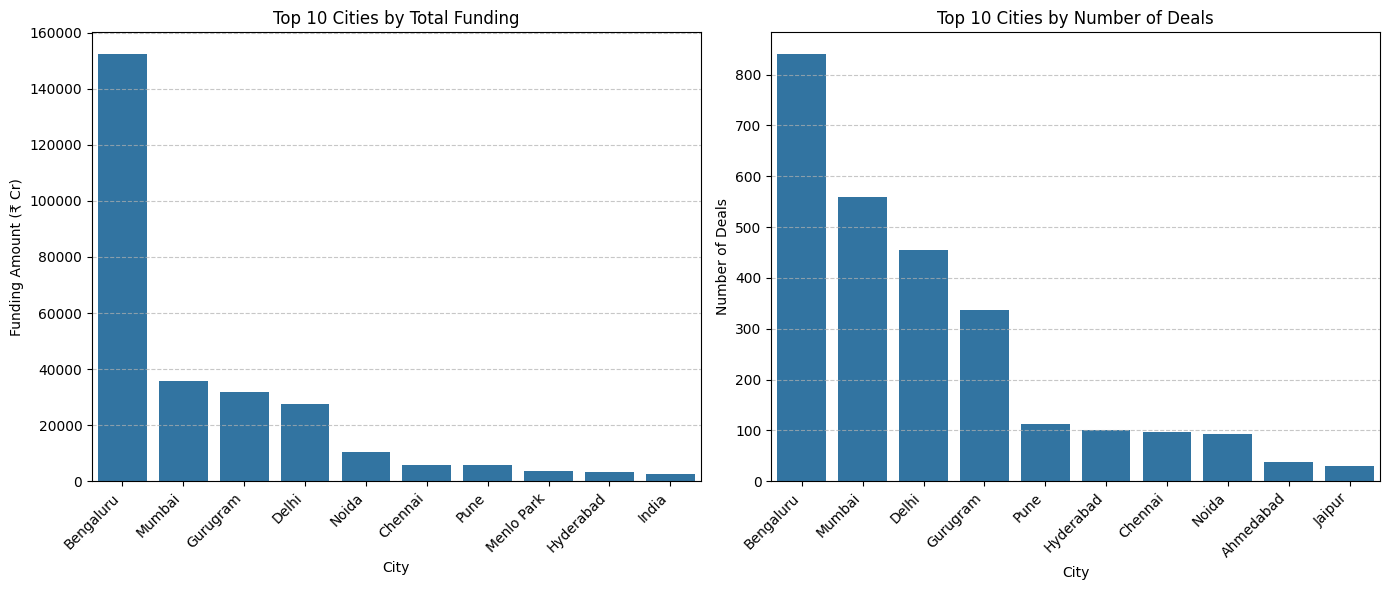

In [96]:
# Top cities by funding amount
city_funding = df.groupby('city')['amount'].sum().sort_values(ascending=False).head(10).reset_index()
city_deals = df.groupby('city').size().sort_values(ascending=False).head(10).reset_index(name='deals')

# Try using Plotly with error handling
try:
    # Top cities by funding amount
    fig = px.bar(
        city_funding,
        x='city',
        y='amount',
        title='Top 10 Cities by Total Funding',
        labels={'amount': 'Funding Amount (₹ Cr)', 'city': 'City'},
        color='amount'
    )
    fig.show()
    
    # Top cities by number of deals
    fig = px.bar(
        city_deals,
        x='city',
        y='deals',
        title='Top 10 Cities by Number of Deals',
        labels={'deals': 'Number of Deals', 'city': 'City'},
        color='deals'
    )
    fig.show()
except Exception as e:
    print(f"Plotly visualization failed: {e}")
    print("Falling back to matplotlib for visualization...")
    
    # Fallback to matplotlib if Plotly fails
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Top cities by funding
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x='city', y='amount', data=city_funding)
    plt.title('Top 10 Cities by Total Funding')
    plt.xlabel('City')
    plt.ylabel('Funding Amount (₹ Cr)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot 2: Top cities by deals
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x='city', y='deals', data=city_deals)
    plt.title('Top 10 Cities by Number of Deals')
    plt.xlabel('City')
    plt.ylabel('Number of Deals')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Plotly visualization failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Falling back to matplotlib for visualization...


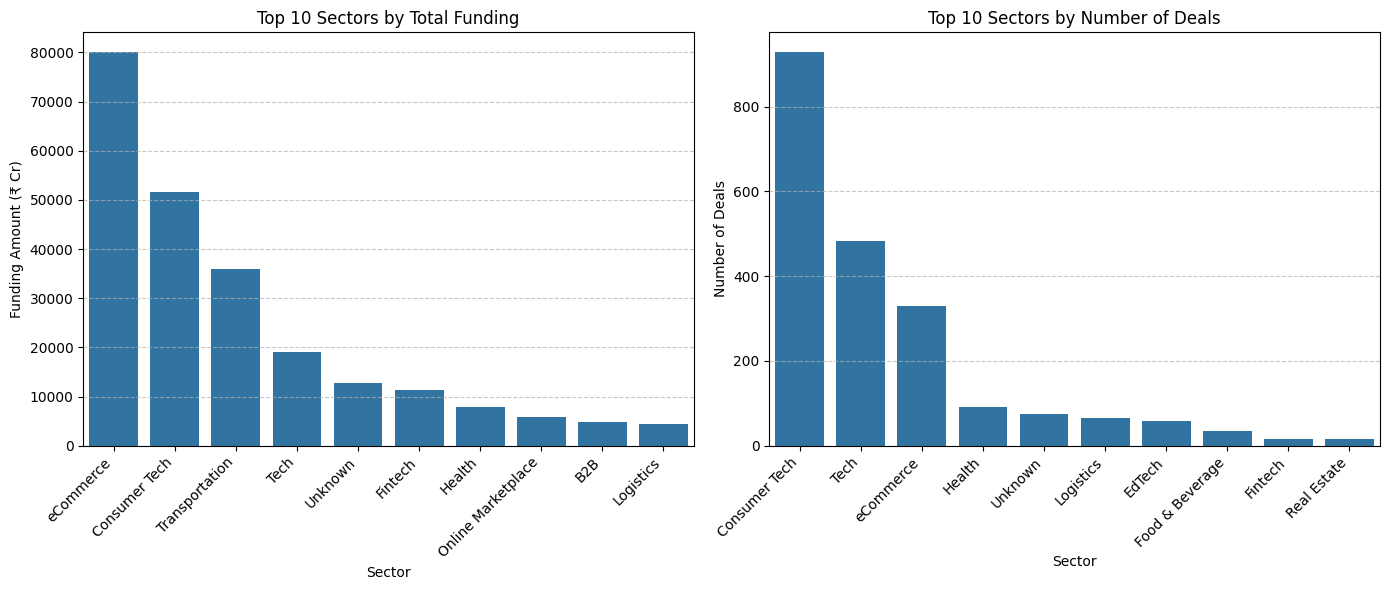

In [97]:
# Top verticals by funding amount
vertical_funding = df.groupby('vertical')['amount'].sum().sort_values(ascending=False).head(10).reset_index()
vertical_deals = df.groupby('vertical').size().sort_values(ascending=False).head(10).reset_index(name='deals')

# Try using Plotly with error handling
try:
    # Top verticals by funding amount
    fig = px.bar(
        vertical_funding,
        x='vertical',
        y='amount',
        title='Top 10 Sectors by Total Funding',
        labels={'amount': 'Funding Amount (₹ Cr)', 'vertical': 'Sector'},
        color='amount'
    )
    fig.show()
    
    # Top verticals by number of deals
    fig = px.bar(
        vertical_deals,
        x='vertical',
        y='deals',
        title='Top 10 Sectors by Number of Deals',
        labels={'deals': 'Number of Deals', 'vertical': 'Sector'},
        color='deals'
    )
    fig.show()
except Exception as e:
    print(f"Plotly visualization failed: {e}")
    print("Falling back to matplotlib for visualization...")
    
    # Fallback to matplotlib if Plotly fails
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Top verticals by funding
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x='vertical', y='amount', data=vertical_funding)
    plt.title('Top 10 Sectors by Total Funding')
    plt.xlabel('Sector')
    plt.ylabel('Funding Amount (₹ Cr)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot 2: Top verticals by deals
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x='vertical', y='deals', data=vertical_deals)
    plt.title('Top 10 Sectors by Number of Deals')
    plt.xlabel('Sector')
    plt.ylabel('Number of Deals')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [98]:
# Funding rounds analysis
round_funding = df.groupby('round')['amount'].sum().sort_values(ascending=False).reset_index()
round_deals = df.groupby('round').size().sort_values(ascending=False).reset_index(name='deals')

fig = px.pie(
    round_funding, 
    values='amount', 
    names='round',
    title='Distribution of Funding by Round'
)
fig.show()

fig = px.pie(
    round_deals, 
    values='deals', 
    names='round',
    title='Distribution of Deals by Round'
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Top funded startups
top_startups = df.groupby('startup')['amount'].sum().sort_values(ascending=False).head(20).reset_index()

fig = px.bar(
    top_startups,
    x='startup',
    y='amount',
    title='Top 20 Startups by Total Funding',
    labels={'amount': 'Funding Amount (₹ Cr)', 'startup': 'Startup'},
    color='amount'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [ ]:
# Time series analysis - funding trends by month
monthly_funding = df.groupby('month_year')['amount'].sum().reset_index()
monthly_funding['month_year'] = pd.to_datetime(monthly_funding['month_year'])

fig = px.line(
    monthly_funding.sort_values('month_year'),
    x='month_year',
    y='amount',
    title='Monthly Funding Trends',
    labels={'amount': 'Funding Amount (₹ Cr)', 'month_year': 'Month'},
    markers=True
)
fig.show()

In [ ]:
# Correlation between investor count and funding amount
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['investor_count'], df['amount'], alpha=0.5)
plt.title('Relationship Between Investor Count and Funding Amount')
plt.xlabel('Number of Investors')
plt.ylabel('Funding Amount (₹ Cr)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Calculate correlation
correlation = df['investor_count'].corr(df['amount'])
print(f"Correlation between investor count and funding amount: {correlation:.2f}")

In [ ]:
# Average funding amount by round
avg_funding_by_round = df.groupby('round')['amount'].mean().sort_values(ascending=False).reset_index()

fig = px.bar(
    avg_funding_by_round,
    x='round',
    y='amount',
    title='Average Funding Amount by Round',
    labels={'amount': 'Average Funding (₹ Cr)', 'round': 'Round'},
    color='amount'
)
fig.show()

In [ ]:
# Funding distribution by quarter and year
quarterly_funding = df.groupby(['year', 'quarter'])['amount'].sum().reset_index()

fig = px.bar(
    quarterly_funding,
    x='quarter',
    y='amount',
    color='year',
    title='Quarterly Funding Trends by Year',
    labels={'amount': 'Funding Amount (₹ Cr)', 'quarter': 'Quarter', 'year': 'Year'},
    barmode='group'
)
fig.show()

In [ ]:
# Save the cleaned data for further analysis
df.to_csv('startup_data_processed.csv', index=False)
print("Cleaned data saved to 'startup_data_processed.csv'")

## Key Insights:

1. **Funding Trends**: 
   - There are clear funding patterns across years with certain periods showing funding booms.
   - The number of deals doesn't always correlate with total funding amount.

2. **City Analysis**:
   - Bengaluru leads in both funding amount and number of deals, followed by Delhi/Gurugram and Mumbai.
   - These three cities form the major startup hubs in India.

3. **Sector Analysis**:
   - eCommerce, Fintech, and Consumer Tech are the top funded sectors.
   - EdTech and Health sectors show promising growth.

4. **Funding Rounds**:
   - Later-stage rounds (Series C and beyond) account for a larger portion of funding despite fewer deals.
   - Seed and early-stage funding show a higher number of deals but lower total funding.

5. **Investor Dynamics**:
   - There's a moderate correlation between the number of investors and funding amount.
   - Certain startups attract a large number of investors consistently across rounds.